# Skin Cancer Classification using ISIC 2019 Dataset
This notebook explores the ISIC 2019 dataset to classify different types of skin cancer. The workflow includes:
- **Data exploration and preprocessing**
- **Feature extraction using Efficient-B3**
- **Training multiple ML models**
- **Comparing performance using accuracy & confusion matrix**
- **Implementing a sample prediction system**

## Dataset Overview
The ISIC 2019 dataset contains images of skin lesions categorized into different skin cancer types. We will analyze and classify these images using  machine learning models.
The data contained 25000 images of skin lesions classified with 9 following classes ranging from benign to malignant skin cancer:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.



# 📂 Load and Explore Dataset
We will load:
- **Metadata file**: Contains information about images.
- **Ground truth labels**: Multi-class classification labels.
- **Image files**: Actual skin lesion images.


In [6]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
#import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from sklearn.utils import resample


In [7]:
# upgrade pip tooling
!pip install -U pip setuptools wheel -q

# install timm without pulling any extra/transitive deps (torch is preinstalled on Kaggle)
!pip install --no-deps timm -q

# verify
import timm, torch
print("timm:", timm.__version__)
print("torch:", torch.__version__)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompat

Metadata Sample:


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male



Ground Truth Sample:


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


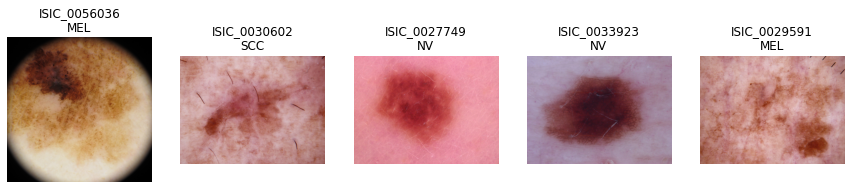

In [8]:
metadata_path = "/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv"
groundtruth_path = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"
image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
metadata_df = pd.read_csv(metadata_path)
groundtruth_df = pd.read_csv(groundtruth_path)

print("Metadata Sample:")
display(metadata_df.head())

print("\nGround Truth Sample:")
display(groundtruth_df.head())

def display_sample_images(image_list, image_dir, groundtruth_df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(image_dir, img_name + ".jpg")

        if not os.path.exists(img_path):
            print(f"Warning: Image {img_name}.jpg not found!")
            axes[i].set_title("Image Not Found")
            axes[i].axis("off")
            continue

        img = cv2.imread(img_path)

        if img is None:
            print(f"Error: Failed to load {img_name}.jpg")
            axes[i].set_title("Load Error")
            axes[i].axis("off")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        row = groundtruth_df[groundtruth_df['image'] == img_name].iloc[:, 1:]
        cancer_type = row.columns[row.values.argmax()]

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{img_name}\n{cancer_type}")

    plt.show()

sample_images = groundtruth_df.sample(5)['image'].values
display_sample_images(sample_images, image_dir, groundtruth_df)


# 📊 Class Distribution
We will visualize the class distribution to understand the imbalance in the dataset.

The graph shows the class distribution of images in the ISIC 2019 dataset, which is used for skin cancer classification. The x-axis represents different types of skin cancer or lesions, while the y-axis shows the number of images corresponding to each category.

Here's a breakdown of the categories and the number of images for each:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.
  
In summary, the dataset is heavily imbalanced, with the "NV" category having significantly more images compared to the other categories. This imbalance might need to be addressed when training machine learning models for skin cancer classification.


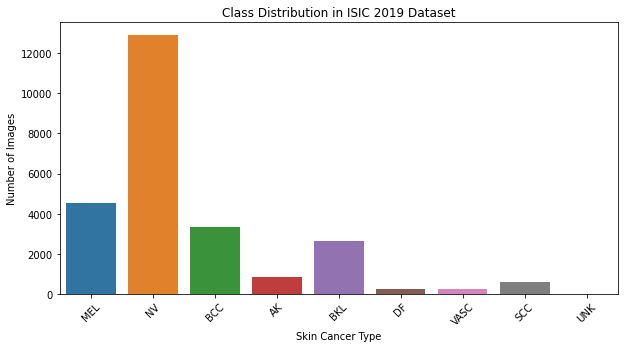

In [9]:
class_counts = groundtruth_df.iloc[:, 1:].sum()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Skin Cancer Type")
plt.ylabel("Number of Images")
plt.title("Class Distribution in ISIC 2019 Dataset")
plt.show()


In [10]:
image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

#  Define image preprocessing for EfficientNet-B3
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  Load Pretrained Model (EfficientNet-B3) and Modify to Output 512D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("efficientnet_b3", pretrained=True)

#  Modify the classifier head to output **512D embeddings**
model.classifier = torch.nn.Linear(model.classifier.in_features, 512)
model = model.to(device)
model.eval()

image_files = []

# Scan and filter valid image files
for file in tqdm(os.listdir(image_dir), desc="Scanning Files", unit="file"):
    if file.endswith(".jpg") or file.endswith(".png"):
        image_files.append(file)  # Store valid image files

# Process images and extract embeddings
embeddings = []
image_names = []
for img_file in tqdm(image_files, desc="Extracting Embeddings", unit="image"):
    img_path = os.path.join(image_dir, img_file)
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Extract embedding
    with torch.no_grad():
        embedding = model(image).cpu().numpy().flatten()  # Now 512D

    # Store image name and embedding separately
    image_names.append(os.path.splitext(img_file)[0])  # Store name without extension
    embeddings.append(embedding)  # Store embedding as list

#  Convert to DataFrame (Expanded Format)
df = pd.DataFrame(embeddings)
df.columns = [str(i) for i in range(512)]
df.insert(0, "image_name", image_names)

df.to_csv("image_embeddings_efficientnet_b3.csv", index=False)

print("✅ Embeddings extracted and saved to image_embeddings_efficientnet_b3.csv")

Downloading:   0%|          | 0.00/49.5M [00:00<?, ?B/s]

Extracting Embeddings: 100%|██████████| 25331/25331 [23:43<00:00, 17.79image/s]


✅ Embeddings extracted and saved to image_embeddings_efficientnet_b3.csv


# 🔍 Feature Extraction using Effcientnet-B3
We will extract **deep learning embeddings** using a pre-trained **Effcientnet-B3** model.


In [15]:
#pd.read_csv('/kaggle/input/image-embeddings-resnet/image_embeddings_expanded (1).csv')
pd.read_csv('/kaggle/working/image_embeddings_efficientnet_b3.csv')


,image_name,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,ISIC_0057312,-0.113508,-0.041379,0.397960,0.126155,-0.346141,0.058749,-0.187675,-0.002699,0.039706,...,0.112213,0.012064,-0.042925,-0.096700,-0.078008,0.025229,0.004380,-0.306008,-0.247864,0.010708
1,ISIC_0014233_downsampled,0.011883,0.096567,-0.204920,0.164129,-0.392104,-0.147609,-0.184430,-0.076040,0.156821,...,0.179168,-0.154154,0.054533,0.162929,-0.053958,-0.016374,-0.146807,-0.330703,-0.524553,0.012533
2,ISIC_0059626,-0.067685,0.070035,0.200408,-0.101127,-0.016742,0.027440,-0.174276,-0.181743,0.209710,...,0.173614,-0.055844,0.078352,-0.222123,-0.150079,-0.069333,-0.076033,-0.311140,0.142816,0.185140
3,ISIC_0056156,-0.155305,-0.065076,0.183969,0.113652,-0.176622,0.184335,-0.442747,-0.182570,0.297865,...,0.372960,0.274089,0.063976,-0.176336,-0.041726,0.008332,-0.060390,-0.355870,-0.296962,-0.002796
4,ISIC_0030912,0.091702,-0.126895,0.149915,-0.182153,-0.226417,0.170782,-0.256491,0.104639,0.354145,...,-0.156537,0.203218,0.051800,-0.040504,-0.136183,-0.069936,-0.086358,-0.203651,-0.129148,-0.061120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0010257,-0.011172,-0.099951,-0.135528,0.133169,-0.049937,0.134417,-0.095245,-0.060647,0.035528,...,-0.182268,0.061822,-0.042542,0.034939,0.202207,-0.007716,-0.066132,-0.116020,-0.047340,0.186757
25327,ISIC_0012539_downsampled,0.020283,-0.000545,-0.102671,0.019380,-0.278300,0.094697,-0.434549,-0.113382,0.074291,...,0.028995,0.201632,0.049443,0.070040,0.069253,0.047759,-0.171240,-0.295573,-0.548420,-0.034876
25328,ISIC_0026236,-0.019631,-0.035838,0.124671,-0.032530,0.041738,0.396434,-0.285384,-0.016903,0.296449,...,0.165436,0.383019,0.110132,-0.005918,0.019789,0.119327,-0.000459,-0.173590,-0.146355,-0.139660
25329,ISIC_0030344,-0.050939,0.078498,-0.033747,0.044867,-0.084611,0.070853,-0.269936,-0.090562,0.346087,...,-0.258429,-0.133261,-0.103471,-0.103339,-0.084305,0.024300,-0.026723,-0.296675,-0.046326,-0.069169


Embeddings extracted from ResNet models are high-dimensional vectors representing an image's features after passing through the network. These embeddings capture essential patterns and structures, condensing the image into a fixed-size vector. They are useful for tasks like image similarity, retrieval, and transfer learning.

# Merging ISIC 2019 Dataset: Ground Truth, Embeddings, and Metadata

## **Overview**
This script merges three datasets related to the **ISIC 2019 skin lesion classification challenge**:
1. **Ground Truth Labels** (`ISIC_2019_Training_GroundTruth.csv`)
2. **Extracted Image Embeddings** (`image_embeddings_expanded.csv`)
3. **Metadata Information** (`ISIC_2019_Training_Metadata.csv`)

In [16]:
df_gt = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv')
df_emb = pd.read_csv('/kaggle/working/image_embeddings_efficientnet_b3.csv')
df_meta = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv')
df_emb.rename(columns={"image_name": "image"}, inplace=True)

#  Perform INNER JOIN on 'image' across all DataFrames
df_merged = df_gt.merge(df_emb, on="image", how="inner").merge(df_meta, on="image", how="inner")
df_merged.to_csv("/kaggle/working/isic_2019_merged.csv", index=False)

print("✅ Merging complete! Saved as isic_2019_merged.csv")

✅ Merging complete! Saved as isic_2019_merged.csv


In [17]:
#df = pd.read_csv('/kaggle/input/isic-merged/isic_2019_merged.csv')
df = pd.read_csv('/kaggle/working/isic_2019_merged.csv')

df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (524) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,...,506,507,508,509,510,511,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.201527,-0.371017,0.018540,-0.053989,0.036243,-0.088380,55.0,anterior torso,NaN,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.007677,0.033529,0.015934,-0.155331,0.053002,-0.005202,30.0,anterior torso,NaN,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016795,-0.088731,-0.013218,-0.117672,-0.099435,0.011249,60.0,upper extremity,NaN,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.108722,-0.152804,0.120363,-0.154346,0.154488,-0.030504,30.0,upper extremity,NaN,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.071640,0.028206,0.047779,-0.281479,-0.079290,-0.125055,80.0,posterior torso,NaN,male


# ISIC 2019 Data Preprocessing

## **Overview**
This script processes the **ISIC 2019 dataset** and prepares it for machine learning models. It includes:
# Data cleaning & preprocessing
- Drop Unnecessary Columns
- Handle Missing Values in 'sex' Column
- One-Hot Encoding for 'anatom_site_general' Column
- Convert One-Hot Encoded Labels to Single Target Class
- Handle Missing Values in Features (X)
- Standardize Features

In [18]:
file_path = "/kaggle/working/isic_2019_merged.csv"

df = pd.read_csv(file_path, low_memory=False)

df = df.drop(columns=['image', 'lesion_id'])

df['sex'] = df['sex'].fillna('unknown')
encoder = LabelEncoder()
df['sex'] = encoder.fit_transform(df['sex'])

df = pd.get_dummies(df, columns=['anatom_site_general'], drop_first=True)

X = df.drop(df.columns[:9], axis=1)
Y = df.iloc[:, :9]
print(Y)

Y = Y.idxmax(axis=1)

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


       MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2      1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4      1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...   ...  ...  ...
25326  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
25327  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0
25328  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25329  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25330  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0

[25331 rows x 9 columns]


### Without SMOTE

### Logistic Regression Model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.21968273
Epoch 3, change: 0.19098708
Epoch 4, change: 0.12692867
Epoch 5, change: 0.09886406
Epoch 6, change: 0.07597221
Epoch 7, change: 0.08130476
Epoch 8, change: 0.06713623
Epoch 9, change: 0.04947711
Epoch 10, change: 0.07583879
Epoch 11, change: 0.05079308
Epoch 12, change: 0.04316459
Epoch 13, change: 0.03600847
Epoch 14, change: 0.05263405
Epoch 15, change: 0.03738320
Epoch 16, change: 0.03835205
Epoch 17, change: 0.06131196
Epoch 18, change: 0.04536942
Epoch 19, change: 0.03206540
Epoch 20, change: 0.03187708
Epoch 21, change: 0.03280899
Epoch 22, change: 0.02494224
Epoch 23, change: 0.02577986
Epoch 24, change: 0.03252952
Epoch 25, change: 0.02486496
Epoch 26, change: 0.02687400
Epoch 27, change: 0.02466929
Epoch 28, change: 0.02909421
Epoch 29, change: 0.02559334
Epoch 30, change: 0.02860549
Epoch 31, change: 0.02170236
Epoch 32, change: 0.02776741
Epoch 33, change: 0.02352232
Epoch 34, change: 0.02389653
Epoch 35, change: 0.036

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.0min finished


              precision    recall  f1-score   support

          AK     0.2581    0.4972    0.3398       177
         BCC     0.6235    0.5562    0.5880       658
         BKL     0.4255    0.4851    0.4534       536
          DF     0.1385    0.3750    0.2022        48
         MEL     0.5538    0.5628    0.5583       915
          NV     0.8908    0.7370    0.8067      2567
         SCC     0.1838    0.4808    0.2660       104
        VASC     0.4444    0.5161    0.4776        62

    accuracy                         0.6357      5067
   macro avg     0.4398    0.5263    0.4615      5067
weighted avg     0.6968    0.6357    0.6589      5067



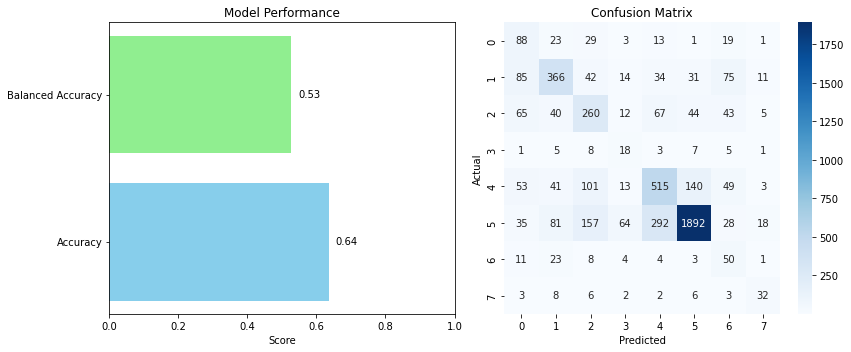

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix
)

# ---------------- Train Logistic Regression ----------------
log_reg = LogisticRegression(
    max_iter=2000,
    solver='saga',
    penalty='l2',
    class_weight="balanced",
    verbose=1
)
log_reg.fit(X_train_scaled, Y_train)

# ---------------- Predictions ----------------
Y_pred = log_reg.predict(X_test_scaled)

# ---------------- Metrics ----------------
accuracy_log_reg = accuracy_score(Y_test, Y_pred)
balanced_acc = balanced_accuracy_score(Y_test, Y_pred)

print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}\n")

print("Classification Report:")
print(classification_report(Y_test, Y_pred, digits=4))

# ---------------- Visualization ----------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Accuracy vs Balanced Accuracy (Horizontal Bars)
metrics = {
    "Accuracy": accuracy_log_reg,
    "Balanced Accuracy": balanced_acc
}
ax[0].barh(list(metrics.keys()), list(metrics.values()),
           color=['skyblue', 'lightgreen'])
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Score")
ax[0].set_title("Model Performance")
for i, (k, v) in enumerate(metrics.items()):
    ax[0].text(v + 0.02, i, f"{v:.2f}", va='center')

# 2. Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


### Support Vector Machine (SVM) Model

SVM Model Accuracy: 0.7545
SVM Balanced Accuracy: 0.4276

Classification Report:
              precision    recall  f1-score   support

          AK     0.5802    0.2655    0.3643       177
         BCC     0.6317    0.8055    0.7081       658
         BKL     0.6793    0.5019    0.5773       536
          DF     0.0000    0.0000    0.0000        48
         MEL     0.7195    0.5858    0.6458       915
          NV     0.8129    0.9408    0.8722      2567
         SCC     0.6522    0.1442    0.2362       104
        VASC     0.9167    0.1774    0.2973        62

    accuracy                         0.7545      5067
   macro avg     0.6241    0.4276    0.4626      5067
weighted avg     0.7405    0.7545    0.7327      5067

SVM model saved as 'svm_model.pkl' successfully!


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


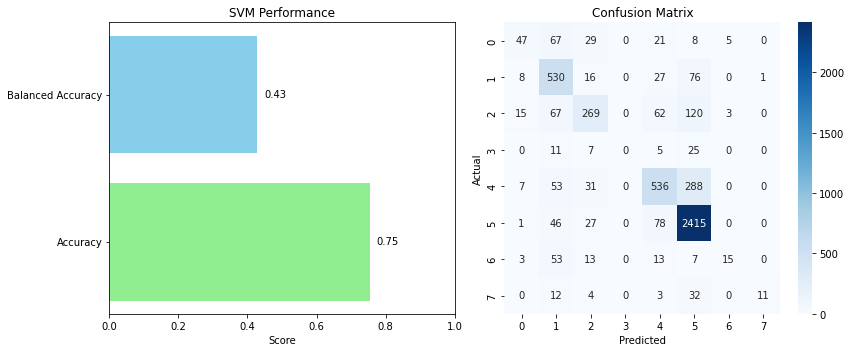

In [14]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.svm import SVC

# ---------------- Train SVM ----------------
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_scaled, Y_train)

# ---------------- Predictions ----------------
Y_pred_svm = svm_model.predict(X_test_scaled)

# ---------------- Metrics ----------------
accuracy_svm = accuracy_score(Y_test, Y_pred_svm)
balanced_acc_svm = balanced_accuracy_score(Y_test, Y_pred_svm)

print(f"SVM Model Accuracy: {accuracy_svm:.4f}")
print(f"SVM Balanced Accuracy: {balanced_acc_svm:.4f}\n")

print("Classification Report:")
print(classification_report(Y_test, Y_pred_svm, digits=4))

# ---------------- Save Model ----------------
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("SVM model saved as 'svm_model.pkl' successfully!")

# ---------------- Visualization ----------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Accuracy vs Balanced Accuracy (Horizontal Bars)
metrics = {
    "Accuracy": accuracy_svm,
    "Balanced Accuracy": balanced_acc_svm
}
ax[0].barh(list(metrics.keys()), list(metrics.values()), 
           color=['lightgreen', 'skyblue'])
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Score")
ax[0].set_title("SVM Performance")
for i, (k, v) in enumerate(metrics.items()):
    ax[0].text(v + 0.02, i, f"{v:.2f}", va='center')

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, Y_pred_svm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


### LIGHTGBM (Tree-based, so no need for feature scaling)

LightGBM Model Accuracy: 0.7127
LightGBM Balanced Accuracy: 0.3920

Classification Report:
              precision    recall  f1-score   support

          AK     0.6410    0.2825    0.3922       177
         BCC     0.5940    0.6960    0.6410       658
         BKL     0.5793    0.3545    0.4398       536
          DF     0.6667    0.0833    0.1481        48
         MEL     0.6367    0.5268    0.5766       915
          NV     0.7784    0.9361    0.8500      2567
         SCC     0.5714    0.1923    0.2878       104
        VASC     0.8000    0.0645    0.1194        62

    accuracy                         0.7127      5067
   macro avg     0.6584    0.3920    0.4319      5067
weighted avg     0.6980    0.7127    0.6870      5067

LightGBM model saved as 'lgbm_model.pkl' successfully!


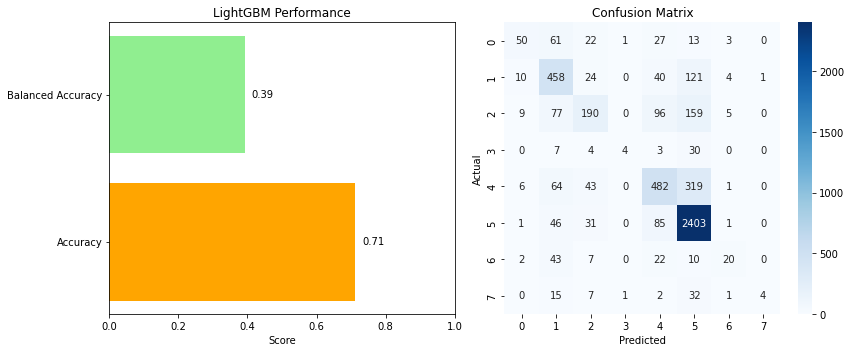

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix
)

# ---------------- Train LightGBM ----------------
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    is_unbalance=True
)
lgbm_model.fit(X_train_scaled, Y_train)

# ---------------- Predictions ----------------
Y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# ---------------- Metrics ----------------
accuracy_lgbm = accuracy_score(Y_test, Y_pred_lgbm)
balanced_acc_lgbm = balanced_accuracy_score(Y_test, Y_pred_lgbm)

print(f"LightGBM Model Accuracy: {accuracy_lgbm:.4f}")
print(f"LightGBM Balanced Accuracy: {balanced_acc_lgbm:.4f}\n")

print("Classification Report:")
print(classification_report(Y_test, Y_pred_lgbm, digits=4))

# ---------------- Save Model ----------------
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)
print("LightGBM model saved as 'lgbm_model.pkl' successfully!")

# ---------------- Visualization ----------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Accuracy vs Balanced Accuracy (Horizontal Bars)
metrics = {
    "Accuracy": accuracy_lgbm,
    "Balanced Accuracy": balanced_acc_lgbm
}
ax[0].barh(list(metrics.keys()), list(metrics.values()), 
           color=['orange', 'lightgreen'])
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Score")
ax[0].set_title("LightGBM Performance")
for i, (k, v) in enumerate(metrics.items()):
    ax[0].text(v + 0.02, i, f"{v:.2f}", va='center')

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, Y_pred_lgbm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


### With SMOTE

In [19]:
# If needed: !pip install -q imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

# --- Apply SMOTE only on the TRAIN split ---
print("Before SMOTE:", Counter(Y_train))
sm = SMOTE(random_state=42, k_neighbors=5)  # try k_neighbors=3 if very tiny minority classes
X_train_sm, Y_train_sm = sm.fit_resample(X_train_scaled, Y_train)
print("After  SMOTE:", Counter(Y_train_sm))

# --- Re-train your model on the resampled data ---
log_reg = LogisticRegression(
    max_iter=2000, solver='saga', penalty='l2', class_weight=None, verbose=1
)
log_reg.fit(X_train_sm, Y_train_sm)

# --- Evaluate (unchanged) ---
Y_pred = log_reg.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
acc = accuracy_score(Y_test, Y_pred)
bacc = balanced_accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bacc:.4f}\n")
print(classification_report(Y_test, Y_pred, digits=4))

# (Your plotting code can stay the same)


Before SMOTE: Counter({'NV': 10308, 'MEL': 3607, 'BCC': 2665, 'BKL': 2088, 'AK': 690, 'SCC': 524, 'VASC': 191, 'DF': 191})
After  SMOTE: Counter({'AK': 10308, 'NV': 10308, 'BCC': 10308, 'MEL': 10308, 'BKL': 10308, 'VASC': 10308, 'SCC': 10308, 'DF': 10308})


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.11544105
Epoch 3, change: 0.06323979
Epoch 4, change: 0.05373916
Epoch 5, change: 0.04130389
Epoch 6, change: 0.03937120
Epoch 7, change: 0.03673150
Epoch 8, change: 0.03252762
Epoch 9, change: 0.02989810
Epoch 10, change: 0.02844408
Epoch 11, change: 0.02699744
Epoch 12, change: 0.02503677
Epoch 13, change: 0.02394807
Epoch 14, change: 0.02242559
Epoch 15, change: 0.02106121
Epoch 16, change: 0.01974599
Epoch 17, change: 0.01867912
Epoch 18, change: 0.01770646
Epoch 19, change: 0.01652264
Epoch 20, change: 0.01575761
Epoch 21, change: 0.01517755
Epoch 22, change: 0.01449690
Epoch 23, change: 0.01411342
Epoch 24, change: 0.01349067
Epoch 25, change: 0.01304891
Epoch 26, change: 0.01258769
Epoch 27, change: 0.01228332
Epoch 28, change: 0.01178035
Epoch 29, change: 0.01147690
Epoch 30, change: 0.01111864
Epoch 31, change: 0.01079665
Epoch 32, change: 0.01049543
Epoch 33, change: 0.01019238
Epoch 34, change: 0.00981640
Epoch 35, change: 0.009

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 55.3min finished


              precision    recall  f1-score   support

          AK     0.2468    0.4350    0.3149       177
         BCC     0.6040    0.5517    0.5766       658
         BKL     0.4043    0.4534    0.4274       536
          DF     0.2000    0.4583    0.2785        48
         MEL     0.5452    0.5607    0.5528       915
          NV     0.8880    0.7441    0.8097      2567
         SCC     0.1516    0.4038    0.2205       104
        VASC     0.4730    0.5645    0.5147        62

    accuracy                         0.6325      5067
   macro avg     0.4391    0.5214    0.4619      5067
weighted avg     0.6889    0.6325    0.6546      5067



SVM (SMOTE) Accuracy          : 0.7821
SVM (SMOTE) Balanced Accuracy : 0.6252
SVM (SMOTE) Macro F1          : 0.6672

Classification Report (macro/weighted at bottom):
              precision  recall  f1-score    support
AK               0.5570  0.4972    0.5254   177.0000
BCC              0.7043  0.8146    0.7555   658.0000
BKL              0.6485  0.6231    0.6356   536.0000
DF               0.8696  0.4167    0.5634    48.0000
MEL              0.7005  0.6721    0.6860   915.0000
NV               0.8732  0.8878    0.8804  2567.0000
SCC              0.6591  0.5577    0.6042   104.0000
VASC             0.9706  0.5323    0.6875    62.0000
accuracy         0.7821  0.7821    0.7821     0.7821
macro avg        0.7478  0.6252    0.6672  5067.0000
weighted avg     0.7820  0.7821    0.7798  5067.0000
Model saved as 'svm_smote_model.pkl', report saved as 'svm_smote_classification_report.csv'.


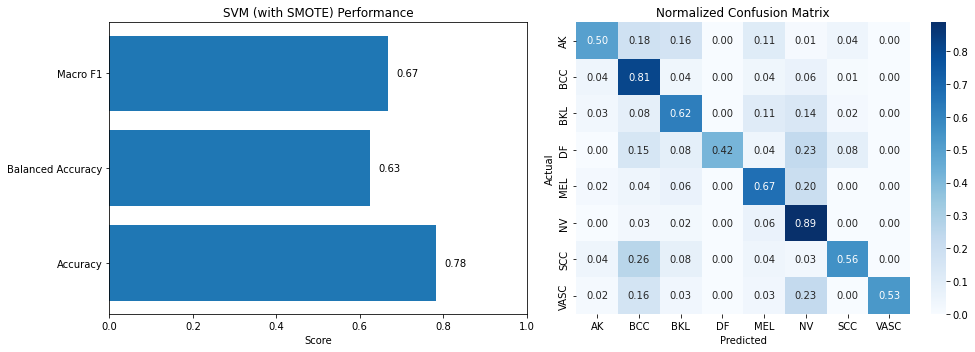

In [20]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.svm import SVC

# --- SMOTE (train-only) via an imblearn Pipeline ---
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# ===========================
# 1) Train with SMOTE
# ===========================
pipe = Pipeline(steps=[
    ("smote", SMOTE(random_state=42, k_neighbors=5)),   # if minority classes are tiny, try k_neighbors=3
    ("clf", SVC(kernel='rbf', C=1, gamma='scale'))      # don't use class_weight when using SMOTE
])

pipe.fit(X_train_scaled, Y_train)

# ===========================
# 2) Predict & Metrics
# ===========================
Y_pred_svm = pipe.predict(X_test_scaled)

accuracy_svm       = accuracy_score(Y_test, Y_pred_svm)
balanced_acc_svm   = balanced_accuracy_score(Y_test, Y_pred_svm)
macro_f1_svm       = f1_score(Y_test, Y_pred_svm, average="macro")

print(f"SVM (SMOTE) Accuracy          : {accuracy_svm:.4f}")
print(f"SVM (SMOTE) Balanced Accuracy : {balanced_acc_svm:.4f}")
print(f"SVM (SMOTE) Macro F1          : {macro_f1_svm:.4f}\n")

# Per-class report as dict -> DataFrame (handy to inspect/save)
report_dict = classification_report(Y_test, Y_pred_svm, output_dict=True, digits=4)
report_df = pd.DataFrame(report_dict).T
print("Classification Report (macro/weighted at bottom):")
print(report_df.round(4))

# Save per-class metrics to CSV
report_df.to_csv("svm_smote_classification_report.csv", index=True)

# ===========================
# 3) Save the trained model
# ===========================
with open('svm_smote_model.pkl', 'wb') as f:
    pickle.dump(pipe, f)
print("Model saved as 'svm_smote_model.pkl', report saved as 'svm_smote_classification_report.csv'.")

# ===========================
# 4) Visualization
# ===========================
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# (A) Accuracy / Balanced Acc / Macro-F1
metrics = {
    "Accuracy": accuracy_svm,
    "Balanced Accuracy": balanced_acc_svm,
    "Macro F1": macro_f1_svm
}
ax[0].barh(list(metrics.keys()), list(metrics.values()))
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Score")
ax[0].set_title("SVM (with SMOTE) Performance")
for i, (k, v) in enumerate(metrics.items()):
    ax[0].text(v + 0.02, i, f"{v:.2f}", va='center')

# (B) Normalized Confusion Matrix (row-normalized = per-class recall)
cm_norm = confusion_matrix(Y_test, Y_pred_svm, normalize="true")
# Optional class labels for axes:
try:
    # If you already have a list like class_names = ["AK","BCC","BKL","DF","MEL","NV","SCC","VASC","UNK"]
    class_names = class_names  # comment out if not defined
except NameError:
    # Fallback: infer from Y_test
    class_names = sorted(list(set(Y_test)))

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=ax[1],
            xticklabels=class_names, yticklabels=class_names)
ax[1].set_title("Normalized Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
